## Energía Inteligente: Detección y clasificación de fallas en el sistema de transmisión de energía eléctrica utilizando redes neuronales

- Estela Monserrat Arriaga Santana

- Julián Rosas Scull

## EDA (Exploratory Data Analysis)

In [1]:
# Sirve para que no salgan los warnings de tipo FutureWarning, para algunas graficas de matplotlib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# pandas se utiliza para manipulación de datos y lectura de los datos
import pandas as pd

In [3]:
# Cargar los datos
df = pd.read_csv("./data/classData.csv")
# Mostar los primeros 5 registros
df.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


## Análisis de la base

In [4]:
# Cantidad total de observaciones
print("Cantidad total de observaciones: ", df.shape[0])


Cantidad total de observaciones:  7861


## Columnas e instancias

In [5]:
# Cantidad de columnas e instancias
num_columns = df.shape[1]
num_instances = df.shape[0]
print(f"Cantidad de columnas: {num_columns}")
print(f"Cantidad de instancias: {num_instances}")

# Tipo de dato de cada columna
data_types = df.dtypes
data_types

Cantidad de columnas: 10
Cantidad de instancias: 7861


G       int64
C       int64
B       int64
A       int64
Ia    float64
Ib    float64
Ic    float64
Va    float64
Vb    float64
Vc    float64
dtype: object

## Cantidad de columnas por tipo de dato

In [6]:
# Cantidad de columnas por tipo de dato
data_types.value_counts()

float64    6
int64      4
Name: count, dtype: int64

Nuestras columnas dependen de 2 tipos de datos, enteros y flotantes. Por lo que va a hacer crucial para la manipulación de los datos convertir los tipos enteros a tipos flotantes. Esto para comparar variables objetivos, etc.

## Cantidad de Columnas e Instancias y Tipo de Dato de Cada Columna

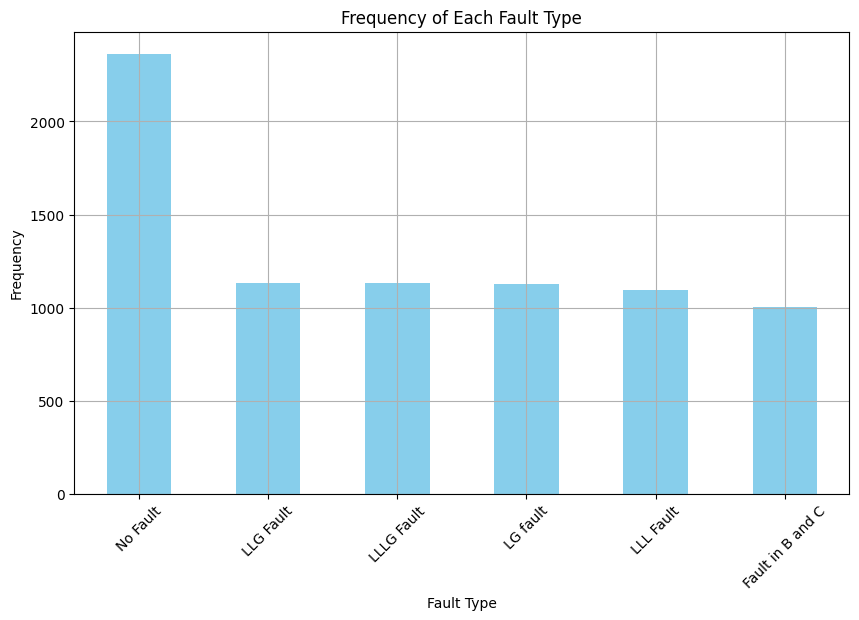

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def classify_fault(row):
    G, C, B, A = row['G'], row['C'], row['B'], row['A']
    if (G, C, B, A) == (0, 0, 0, 0): 
        return 'No Fault'
    elif (G, C, B, A) == (1, 0, 0, 1): 
        return 'LG fault'
    elif (G, C, B, A) == (0, 0, 1, 1): 
        return 'LL fault'
    elif (G, C, B, A) == (1, 0, 1, 1): 
        return 'LLG Fault'
    elif (G, C, B, A) == (0, 1, 1, 1): 
        return 'LLL Fault'
    elif (G, C, B, A) == (1, 1, 1, 1):
        return 'LLLG Fault'
    elif (G,C,B,A) == (0,1,1,0):
        return 'Fault in B and C'

# Apply this function to each row
df['Fault Type'] = df.apply(classify_fault, axis=1)
# Count the occurrences of each fault type
fault_counts = df['Fault Type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
fault_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

Como podemos ver hay una gran diferencia entre la distribucion de líneas de transmisión que no tuvieron falla, que las que si tuvieron en sus diversas fases. Siendo así, una diferencia del mas del doble entre ellas. Notemos de igual manera que las que si tuvieron error en alguna de sus fases estan bien balanceadas, variando en aproximadamente ~100 cada una.

Así mismo, existe una configuración la cual no etsa siendo considerada en el dataset pero que nosotros la ponemos, y es la de (0,1,1,0), la cual indica que hubo una falla en la fase B y C. 

Estos dos problemas son el inicio de nuestra limpieza de datos, ya que nos indica primeramente que hay que realizar una estratificación entre la clase que no hubo falla y las que si, y que la configuración (0,1,1,0) según el dataset no es válida, por lo que hay que escoger si investigar más del tema y el porqué no es válida o si solo no fue considerada, o bien omitir todos los ejemplares con esta configuración.

## Identificación de datos faltantes

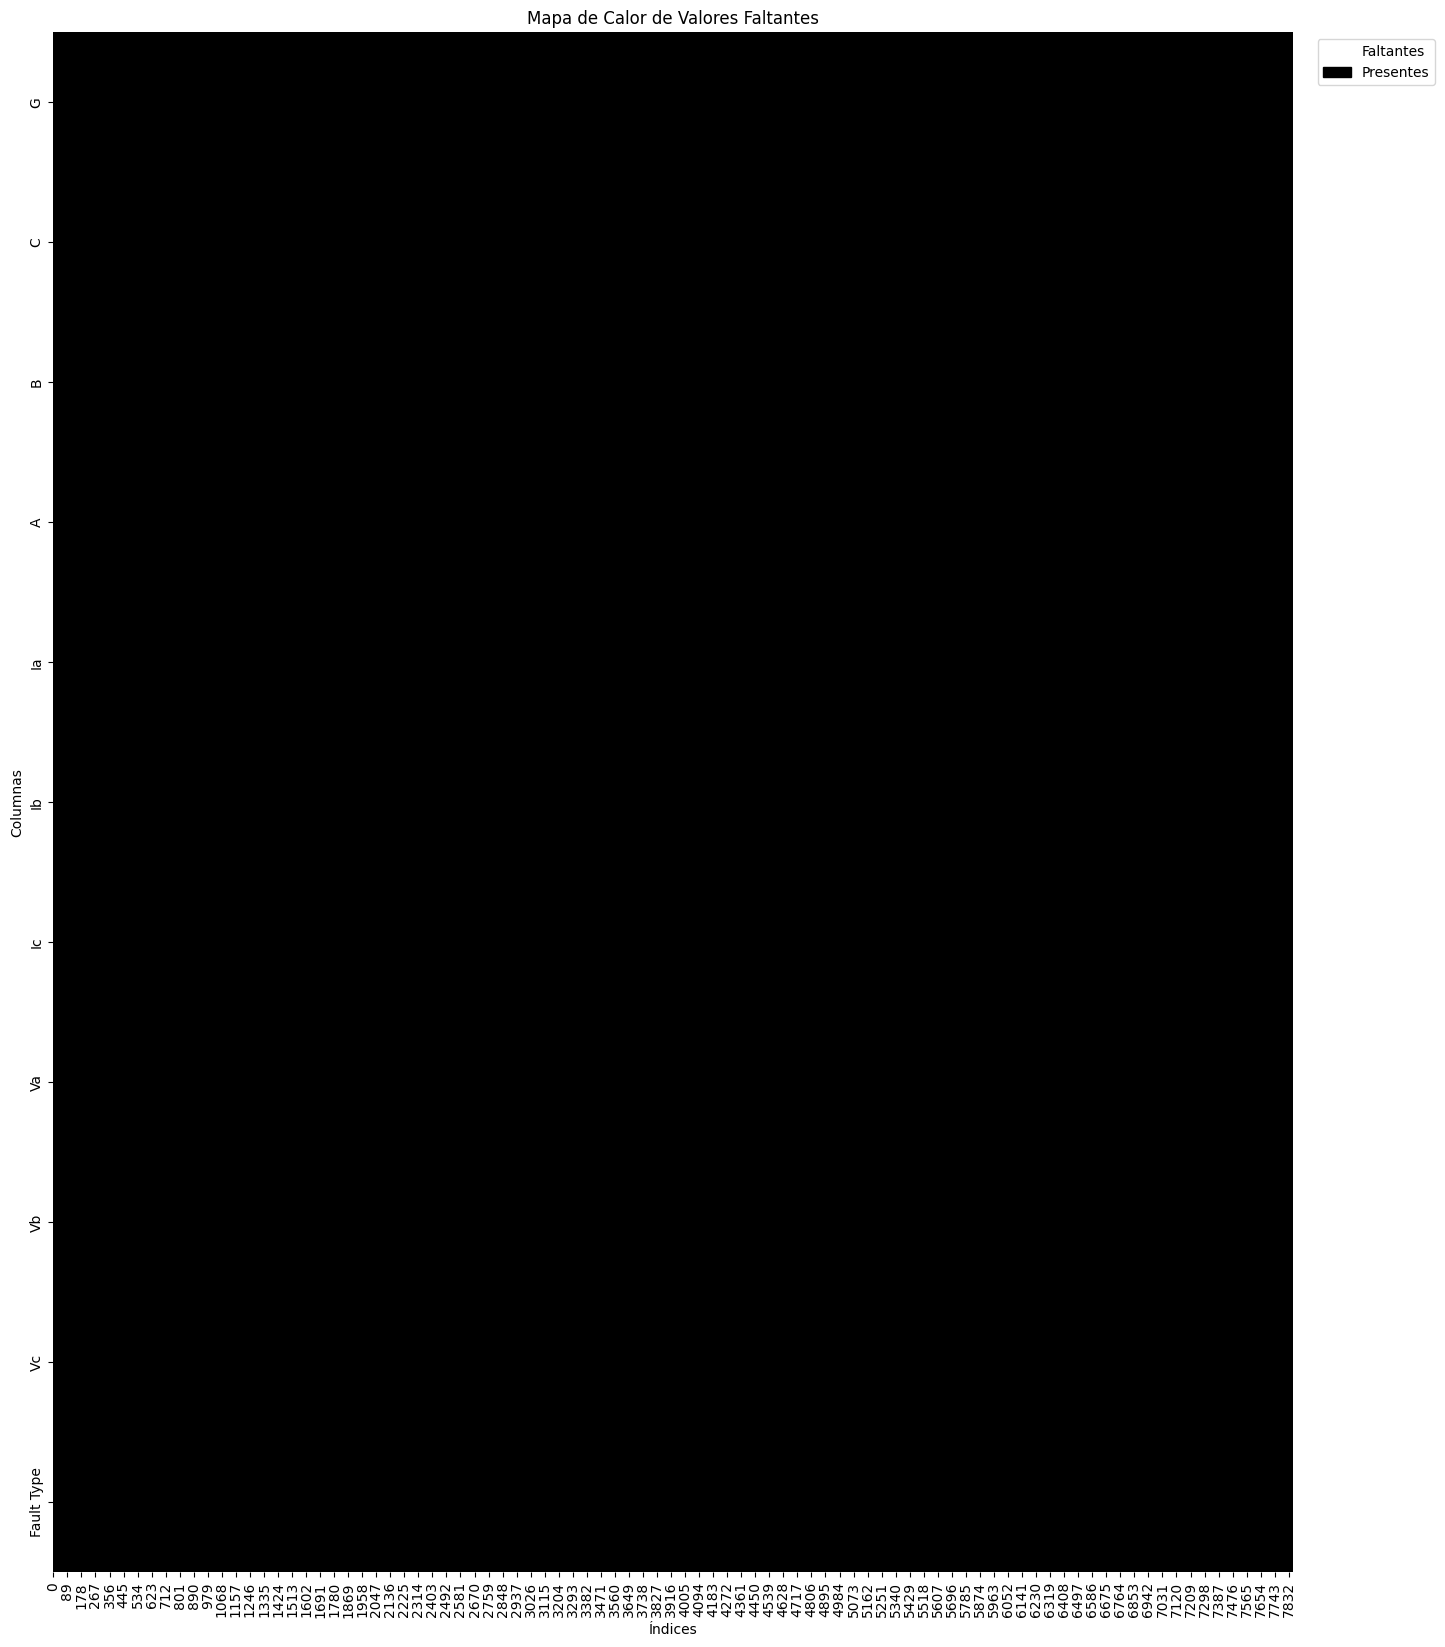

In [8]:
import matplotlib.patches as mpatches

# Mapa de calor invertido con todas las columnas y leyenda
plt.figure(figsize=(16, 20))
sns.heatmap(df.isnull().transpose(), cbar=False, cmap="binary_r", yticklabels=True)
plt.title("Mapa de Calor de Valores Faltantes")
plt.xlabel("Índices")
plt.ylabel("Columnas")

# Añadir leyenda
legend_labels = [
    mpatches.Patch(color="white", label="Faltantes"),
    mpatches.Patch(color="black", label="Presentes"),
]
plt.legend(handles=legend_labels, loc="upper right", bbox_to_anchor=(1.12, 1))
plt.show()

Considerando la información de arriba, podemos notar que no existen los valores nulos.
No obstante, este enfoque visual sirve principalmente como una inspección general. Para un análisis más detallado de los datos faltantes, es recomendable emplear otras herramientas específicas.

In [9]:
# Cantidad de valores faltantes por columna
missing_values = df.isnull().sum()
# Imprimir cantidad de valores faltantes
print(missing_values)

G             0
C             0
B             0
A             0
Ia            0
Ib            0
Ic            0
Va            0
Vb            0
Vc            0
Fault Type    0
dtype: int64


# Rango de columnas



In [10]:
# Obtener columnas numéricas
numeric_cols = df.select_dtypes(include=["number"]).columns

# Calcular y mostrar rangos
ranges = df[numeric_cols].agg(["min", "max"])
ranges

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
min,0,0,0,0,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
max,1,1,1,1,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


Notando que nuestro conjunto de entrenamiento (y por ende de entrada) varía por cada columna uniformemente en aproximadamente 2 veces su valor. Y que existe tanto valores muy grandes como valores muy pequeños, por lo que ésto nos dice que debe de existir una normalización con la finalidad de facilitar el entrenamiento y no haya problemas de desvanecimiento en el descenso por el gradiente.

# Matriz de Correlación

In [11]:
# Obtener columnas categóricas, para saber cuales quitar
categorical_cols = df.select_dtypes(include=["object"]).columns

# Quedarse con las columnas numéricas solamente, pero no asignar a df
# La variable numeric_cols la obtuvimos en un paso anterior.
df_numeric = df[numeric_cols]

# Imprimir la cantidad de columnas numéricas
print(f"Cantidad de columnas numéricas: {df_numeric.shape[1]}")

# Matriz de correlación usando pandas
correlation_matrix = df_numeric.corr()
# Mostrar matriz de correlación
correlation_matrix

Cantidad de columnas numéricas: 10


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
G,1.000000,-0.137611,0.196609,0.755273,0.041310,-0.031068,-0.003156,0.023808,-0.024048,0.002122
C,-0.137611,1.000000,0.747612,0.199335,0.000232,-0.109211,0.164323,0.018188,-0.068840,0.052998
B,0.196609,0.747612,1.000000,0.448807,0.014102,-0.139981,0.133321,0.037128,-0.075973,0.042473
A,0.755273,0.199335,0.448807,1.000000,0.036341,-0.074905,0.054071,0.029940,-0.053036,0.025873
Ia,0.041310,0.000232,0.014102,0.036341,1.000000,-0.374241,-0.276457,0.035682,-0.274612,0.246043
Ib,-0.031068,-0.109211,-0.139981,-0.074905,-0.374241,1.000000,-0.528291,0.029118,0.032101,-0.060023
Ic,-0.003156,0.164323,0.133321,0.054071,-0.276457,-0.528291,1.000000,-0.069137,-0.056967,0.122919
Va,0.023808,0.018188,0.037128,0.029940,0.035682,0.029118,-0.069137,1.000000,-0.480247,-0.450225
Vb,-0.024048,-0.068840,-0.075973,-0.053036,-0.274612,0.032101,-0.056967,-0.480247,1.000000,-0.566986
Vc,0.002122,0.052998,0.042473,0.025873,0.246043,-0.060023,0.122919,-0.450225,-0.566986,1.000000


Representada visualmente


<Axes: title={'center': 'Matriz de Correlación'}>

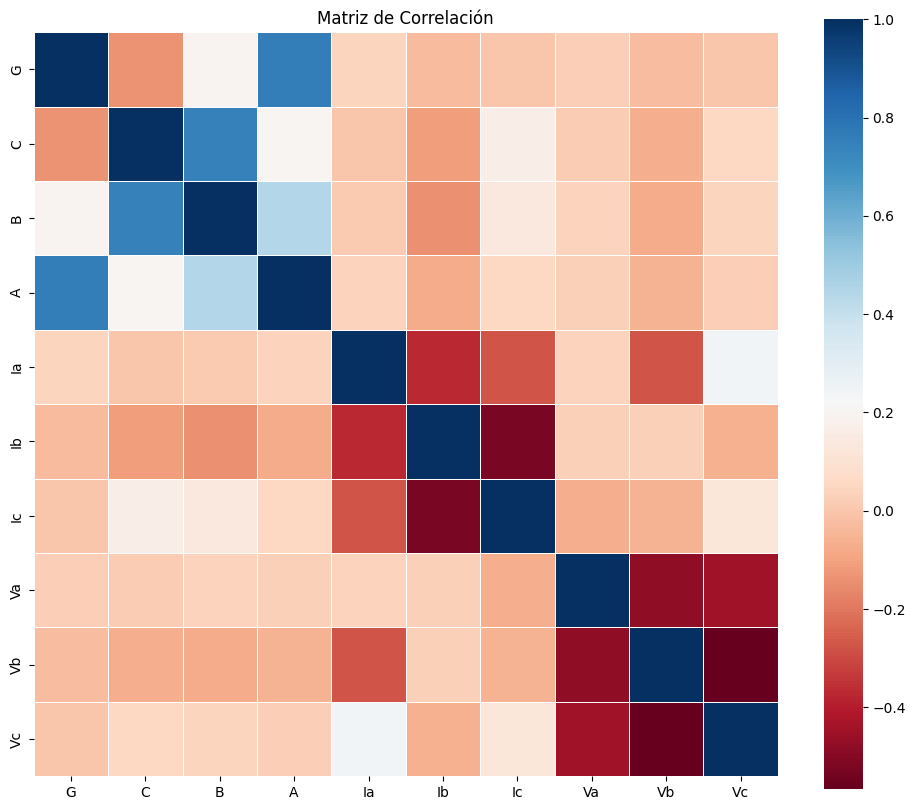

In [12]:
# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
plt.title("Matriz de Correlación")
# Add heatmap with grid
sns.heatmap(
    correlation_matrix,  # Matriz de correlación
    cmap="RdBu",  # Color con gradiente de rojo a azul
    annot=False,  # No mostrar valores en las celdas, se puede cambiar a True
    square=True,  # Hacer los cuadrados iguales
    linecolor="white",  # Color de las líneas que separan las celdas
    linewidths=0.5,  # Grosor de las líneas que separan las celdas
)

# Arquitectura de la Red Neuronal

Proponemos dos arquitecturas de perceptrón multicapa, una interpretando como un conjunto de escenarios la salida (es decir, en _one hot encoding_), y la otra como esta planteada el problema (con 4 posibles salidas y cada una con su valor binario de falla en la fase correspondiente).

Empezemos con la solución **sin one hot encoding**:

Proponemos para la solución del problema, un perceptrón multicapa con 3 capas, una de entrada con 6 neuronas, una escondida con 38 neuronas y una de salida con 4 neuronas.

De las cuales:

- 6 de entrada representan los voltajes e intensidades correspondientes $(Ia,Ib,Ic,Va,Vb,Vc)$.
- 38 en la capa escondida por que al basarnos del artículo <https://springerplus.springeropen.com/articles/10.1186/s40064-015-1080-x#:~:text=section%20is%20conclusion.-,Artificial%20neural%20network,form%20can%20be%20dealt%20with.>
- 4 neuronas de salida, cada una representando el valor binario de la falla en la fase correspondiente.



In [13]:
output_wo_oh =  df.iloc[:, :4]
input_wo_oh =  df.iloc[:,4:-1]



print(output_wo_oh.shape)
print(input_wo_oh.shape)


(7861, 4)
(7861, 6)


In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

#Definimos el dispositivo que se usará.
device = torch.device('cpu')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder

In [15]:
class Electrical_nn (nn.Module):
     def __init__(self,input_size,hidden,output_size):
        '''
        Constructor con las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Electrical_nn,self).__init__()
        self.input_layer = nn.Linear(input_size, hidden)
        self.output_layer = nn.Linear(hidden, output_size)
        self.activation = nn.Sigmoid()
        self.hist = []
        
     def forward(self,x):
        '''
        Propagacion hacia adelante
        '''
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
      #   x = self.activation(x)
        return x
     
     def train(self, X, Y, optimizer, steps, loss_func):
        '''
        Función de entrenamiento ya cuenta con el backpropagate. Se usa loss_func como parámetro para probar con las distintas funciones
        de pérdida
        '''     
        for step in range(steps):
            optimizer.zero_grad()
            output = self.forward(X)
            loss = loss_func(output, Y)
            loss.backward()
            optimizer.step()
            
            self.hist.append(loss.item())
            print("Ciclo {step} error: {loss} ".format(step=step, loss= loss))
            
        plt.plot(self.hist)
        plt.title("Progreso error")
        plt.xlabel("ciclo")
        plt.ylabel("error")
        plt.show()
      

## Normalizacion de la entrada con MinMaxScaler

In [16]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(input_wo_oh)

print(x_normalized.shape)



(7861, 6)


In [17]:
xtrain,xtest,ytrain,ytest = train_test_split(x_normalized,output_wo_oh,train_size=0.8,stratify=output_wo_oh)

xtrain = torch.tensor(xtrain,dtype=torch.float32)
xtest = torch.tensor(xtest,dtype=torch.float32)
ytrain = torch.tensor(ytrain.values,dtype=torch.float32)
ytest = torch.tensor(ytest.values,dtype=torch.float32)


print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288, 4])
torch.Size([1573, 4])


## Entrenamiento

Ciclo 0 error: 2.7610020637512207 
Ciclo 1 error: 2.7107601165771484 
Ciclo 2 error: 2.7099037170410156 
Ciclo 3 error: 2.709892511367798 
Ciclo 4 error: 2.709885358810425 
Ciclo 5 error: 2.709878921508789 
Ciclo 6 error: 2.709872007369995 
Ciclo 7 error: 2.7098653316497803 
Ciclo 8 error: 2.7098581790924072 
Ciclo 9 error: 2.7098515033721924 
Ciclo 10 error: 2.7098450660705566 
Ciclo 11 error: 2.7098379135131836 
Ciclo 12 error: 2.709831714630127 
Ciclo 13 error: 2.709824562072754 
Ciclo 14 error: 2.709818124771118 
Ciclo 15 error: 2.709811210632324 
Ciclo 16 error: 2.7098042964935303 
Ciclo 17 error: 2.7097978591918945 
Ciclo 18 error: 2.7097909450531006 
Ciclo 19 error: 2.709784507751465 
Ciclo 20 error: 2.709777593612671 
Ciclo 21 error: 2.709771156311035 
Ciclo 22 error: 2.7097647190093994 
Ciclo 23 error: 2.7097580432891846 
Ciclo 24 error: 2.709751605987549 
Ciclo 25 error: 2.709744691848755 
Ciclo 26 error: 2.7097384929656982 
Ciclo 27 error: 2.7097318172454834 
Ciclo 28 error:

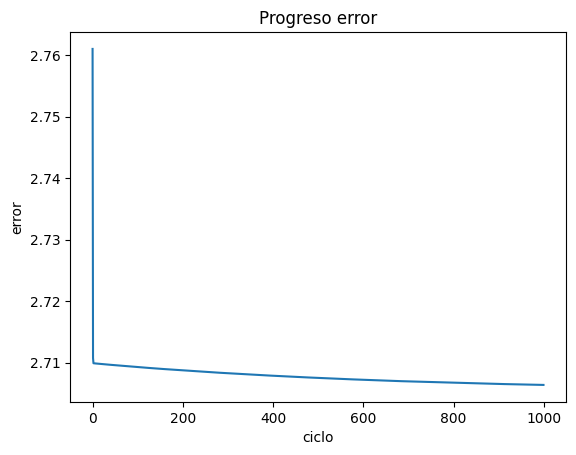

In [18]:
model1 = Electrical_nn(6,38,4)

opt = optim.SGD(model1.parameters(),lr=0.2)
loss_func = nn.CrossEntropyLoss()
model1.train(xtrain,ytrain,opt,1000,loss_func)



In [19]:
arr = [-151.2918124,-9.677451563,85.80016226,0.400749853,-0.132934945,-0.267814907]

arr = torch.Tensor(arr)
val = model1.forward(arr)
val

tensor([-0.8493,  0.7452,  0.5792,  0.0570], grad_fn=<ViewBackward0>)

## Validación
Matriz de confusión:

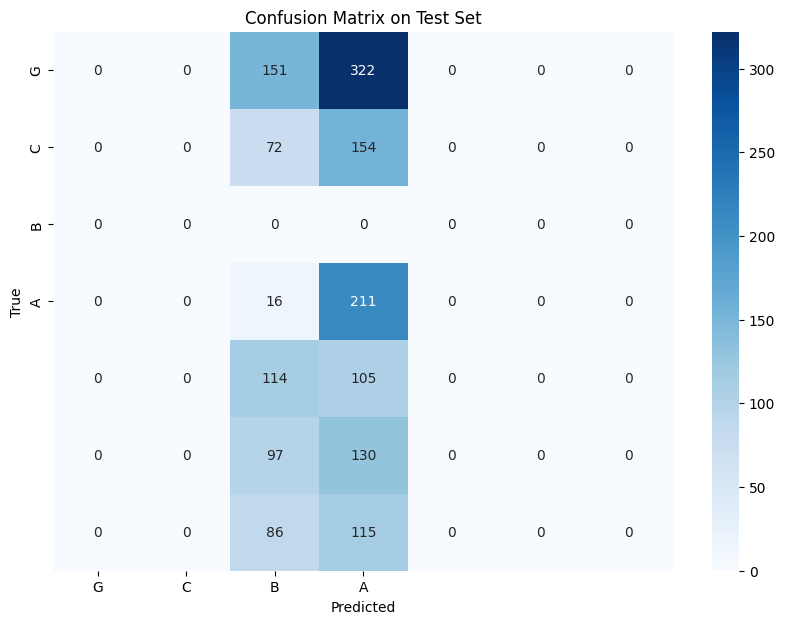

In [35]:
def plot_confusion_matrix(labels, preds, classes, type_of_set):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix on {typeSet}".format(typeSet = type_of_set))
    plt.show()



with torch.no_grad():
  y1_pred = model1(xtest).argmax(dim=1)

classes1 = ["G","C","B","A"]


# classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
plot_confusion_matrix(ytest, y1_pred, classes1, 'Test Set')

## Con One Hot encoding 

Codificación de las clases del 0 al 6.

In [20]:
def tranform_output(row):
    G, C, B, A = row['G'], row['C'], row['B'], row['A']
    if (G, C, B, A) == (0, 0, 0, 0): 
        return 0
    elif (G, C, B, A) == (1, 0, 0, 1): 
        return 1
    elif (G, C, B, A) == (0, 0, 1, 1): 
        return 2
    elif (G, C, B, A) == (1, 0, 1, 1): 
        return 3
    elif (G, C, B, A) == (0, 1, 1, 1): 
        return 4
    elif (G, C, B, A) == (1, 1, 1, 1):
        return 5
    elif (G,C,B,A) == (0,1,1,0):
        return 6
    
output_w_oh = df.apply(tranform_output, axis=1)
input_w_oh =  df.iloc[:,4:-1]



print(output_w_oh.shape)
print(input_w_oh.shape)
input_w_oh

    


(7861,)
(7861, 6)


,Ia,Ib,Ic,Va,Vb,Vc
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


## Normalización de entrada con MinMaxScaler

In [21]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(input_w_oh)

print(x_normalized.shape)
x_normalized

(7861, 6)


array([[0.413869  , 0.49757125, 0.54305757, 0.83998528, 0.38440376,
        0.28435789],
       [0.30936644, 0.46036953, 0.50525074, 0.76760749, 0.39193015,
        0.34925764],
       [0.21514432, 0.4054293 , 0.44963504, 0.72895617, 0.3994813 ,
        0.38031664],
       ...,
       [0.46238877, 0.5233474 , 0.50960887, 0.60345407, 0.04029893,
        0.87214445],
       [0.4626245 , 0.52279168, 0.50993285, 0.61109955, 0.03796598,
        0.86685598],
       [0.46286823, 0.52223521, 0.51024963, 0.61871774, 0.0357486 ,
        0.86147711]])

In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(x_normalized,output_w_oh, train_size=0.8,random_state=42,stratify=output_w_oh)

xtrain = torch.tensor(xtrain,dtype=torch.float32)
xtest = torch.tensor(xtest, dtype=torch.float32)
ytrain = torch.tensor(ytrain.values, dtype=torch.float32)
ytest = torch.tensor(ytest.values,dtype=torch.float32)



print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288])
torch.Size([1573])


Implementar One hot Encoding en el conjunto de entrenamiento y prueba.

In [23]:

ytrain = ytrain.long()

ytrain_oh = torch.zeros((ytrain.size(0),7))


for i in range(ytrain_oh.size(0)):
    ytrain_oh[i,ytrain[i]] = 1

ytest = ytest.long()
ytest_oh = torch.zeros((ytest.size(0),7))

for i in range(ytest.size(0)):
    ytest_oh[i,ytest[i]] = 1


print(xtrain.shape)
print(xtest.shape)
print(ytrain_oh.shape)
print(ytest_oh.shape)


torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288, 7])
torch.Size([1573, 7])


## Entrenamiento

Ciclo 0 error: 2.056840419769287 
Ciclo 1 error: 22.145254135131836 
Ciclo 2 error: 17.12984848022461 
Ciclo 3 error: 4.230644702911377 
Ciclo 4 error: 4.771534442901611 
Ciclo 5 error: 4.570552349090576 
Ciclo 6 error: 3.785781145095825 
Ciclo 7 error: 2.8237407207489014 
Ciclo 8 error: 2.2378416061401367 
Ciclo 9 error: 1.96877121925354 
Ciclo 10 error: 1.8584403991699219 
Ciclo 11 error: 1.816916584968567 
Ciclo 12 error: 1.8041365146636963 
Ciclo 13 error: 1.8030645847320557 
Ciclo 14 error: 1.8064161539077759 
Ciclo 15 error: 1.8109755516052246 
Ciclo 16 error: 1.8152220249176025 
Ciclo 17 error: 1.8183554410934448 
Ciclo 18 error: 1.8199225664138794 
Ciclo 19 error: 1.8196903467178345 
Ciclo 20 error: 1.81761634349823 
Ciclo 21 error: 1.8138294219970703 
Ciclo 22 error: 1.808603048324585 
Ciclo 23 error: 1.8023139238357544 
Ciclo 24 error: 1.7953906059265137 
Ciclo 25 error: 1.7882630825042725 
Ciclo 26 error: 1.7813187837600708 
Ciclo 27 error: 1.7748737335205078 
Ciclo 28 error

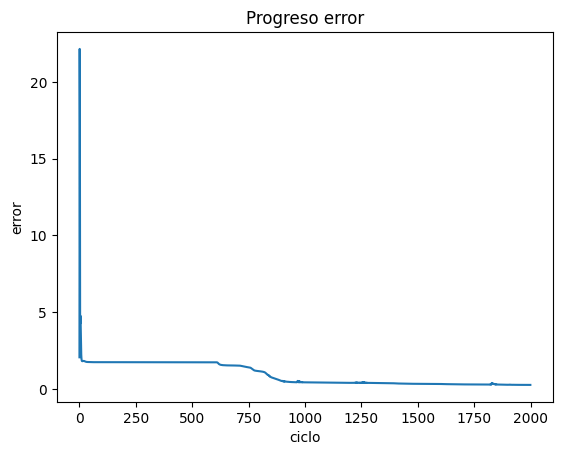

In [24]:
model2 = Electrical_nn(6,256,7)

opt = optim.Adam(model2.parameters(),lr=0.2)
loss_func = nn.CrossEntropyLoss()
model2.train(xtrain,ytrain,opt,2000,loss_func)

# Validación

Matriz de confusión:

In [25]:
def plot_confusion_matrix(labels, preds, classes, type_of_set):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix on {typeSet}".format(typeSet = type_of_set))
    plt.show()

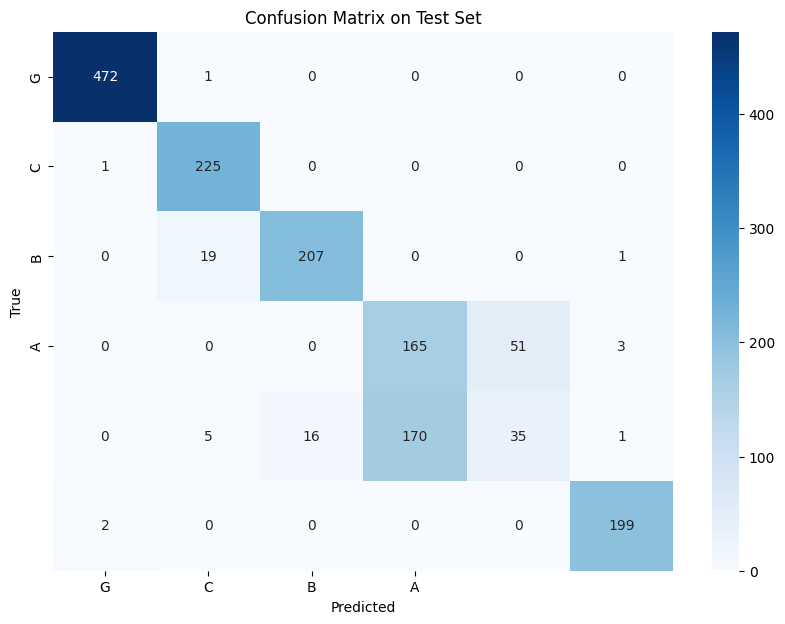

In [36]:

with torch.no_grad():
  y2_pred = model2(xtest).argmax(dim=1)

classes2 = ["G","C","B","A"]


plot_confusion_matrix(ytest, y2_pred, classes2, 'Test Set')

    



Como podemos observar, la red entrenada con implementación de one hot encoding fue mucho más eficiente tanto en error como en validación con la matriz de confusión. 